In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import clear_output
from tqdm import tqdm

In [2]:
device = None
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"
print(device)

cuda:0


In [72]:
class VAE(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 64)
    self.fc5 = nn.Linear(64, 128)
    self.output = nn.Linear(128, output_dim)


  def forward(self, x):

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.output(x)

    return x


  @torch.no_grad
  def generate_image(self, x):

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = x + (0.1**7)*torch.randn(x.shape).to(device)
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    y = self.output(x)

    return y.detach().cpu().numpy().reshape(28,28)

vae = VAE(28*28, 28*28).to(device)
loss_fn_vae = torch.nn.L1Loss()
optimizer_vae = optim.Adam(vae.parameters())

In [73]:
def train_vae(X, y):
  output = vae.forward(X)
  loss = loss_fn_vae(output, y)

  optimizer_vae.zero_grad()
  loss.backward()
  optimizer_vae.step()

  return loss.detach().cpu()

In [74]:
import torchvision
import torchvision.transforms as transforms

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [65]:
images = []
for image, label in train_dataset:
  images.append(image.numpy().squeeze())

In [85]:
epochs = 10000
batch_size = 128
losses = []

for epoch in tqdm(range(epochs)):
  sample_idx = np.random.choice(len(images), batch_size, replace=False).astype(int)
  X = np.array([images[i].flatten() for i in sample_idx])
  y = X.copy()
  X = torch.tensor(X).to(device)
  y = torch.tensor(y).to(device)

  epoch_loss = train_vae(X, y)
  losses.append(epoch_loss)

100%|██████████| 10000/10000 [00:46<00:00, 213.93it/s]


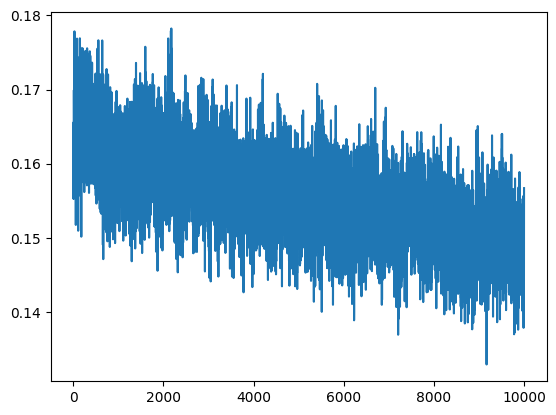

In [86]:
plt.plot(losses)

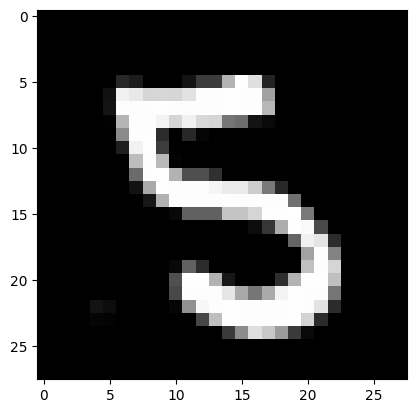

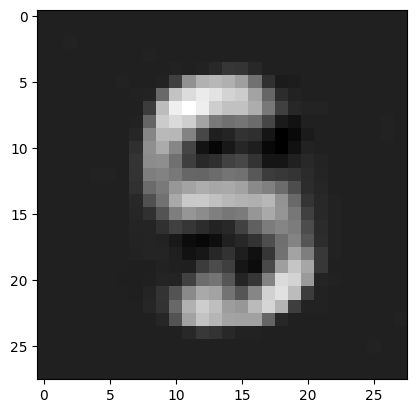

In [90]:
import matplotlib.pyplot as plt

idx = 14799
orig_img = images[idx]
gen_img = vae.generate_image(torch.tensor(orig_img.flatten()).to(device))

plt.imshow(orig_img, cmap='gray')
plt.show()
plt.close()
plt.imshow(gen_img, cmap='gray')
plt.show()
plt.close()